In [24]:
%load_ext autoreload
%autoreload 2
%pylab inline

from IPython.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import pickle
import seaborn as sns
import itertools

sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

In [3]:
from simulations.scenarios import *
from simulations.agent import *
from simulations.utils import Context
from scripts.parse_enron import Message

In [4]:
sns.set_context("paper", font_scale=1.5)
sns.set_style("white")
sns.set_palette("deep")

In [5]:
def compute_enc_stats_in_batches(enc_status_data, link_status_data, mask=None, batch_size=1000):
    log_size = enc_status_data.index[-1] + 1
    batch_stats_data = pd.DataFrame(columns=['Stale key', 'Encrypted',
                                             'Plaintext (initial contact)', 'Plaintext (follow-up)'])
    for i in range(0, log_size, batch_size):
        enc_status_batch = enc_status_data.loc[i:i+batch_size].dropna()
        link_status_batch = link_status_data.loc[i:i+batch_size].dropna()
        if mask is not None:
            mask_batch = mask.loc[i:i+batch_size]
            enc_status_batch = enc_status_batch[mask_batch]
            link_status_batch = link_status_batch[mask_batch]

        if len(enc_status_batch) == 0:
            continue

        #joined_data_batch = pd.concat({'l': link_status_batch, 'e': enc_status_batch}, axis=1).dropna()
        ## This was done to drop rows where enc. status is None.
        #enc_status_batch = joined_data_batch['e'][0]
        #link_status_batch = joined_data_batch['l']
        
        encrypted_prop = np.mean(enc_status_batch == EncStatus.encrypted) * 100
        stale_prop = np.mean(enc_status_batch == EncStatus.stale) * 100
        
        # Proportion of initial contacts
        plain_status_batch = link_status_batch[enc_status_batch == EncStatus.plaintext]
        greeting_mask = plain_status_batch['greeting'] > 0
        followup_mask = plain_status_batch['followup'] > 0
        greeting_prop = np.sum(greeting_mask & ~followup_mask) / len(link_status_batch) * 100
        followup_prop = np.sum(followup_mask) / len(link_status_batch) * 100
        
        batch_stats_data.loc[i] = [stale_prop, encrypted_prop, greeting_prop, followup_prop]
    return batch_stats_data

def visualize_encryption_status_history(scenario_name, enc_status_data, link_status_data, mask=None,
                                        batch_size=1000, legend_kwargs=None, save=False, ax=None):
    if legend_kwargs is None:
        legend_kwargs = {}
    if ax is None:
        fig, ax = plt.subplots()
    
    batch_stats_data = compute_enc_stats_in_batches(enc_status_data, link_status_data, mask, batch_size)
    batch_stats_data.plot.area(ax=ax)
    ax.legend(frameon=True, **legend_kwargs)
    ax.set_title("%s — Encryption status" % scenario_name)
    ax.set_xlabel("Email sent")
    ax.set_ylabel("Emails traffic, %")
    ax.set_ylim(0, 100)
    
    if save:
        plt.savefig(scenario_name.lower().replace(' ', '_') + '_traffic.pdf')

In [15]:
def plot_encryption_status_plots(scenario_name, reports, breakpoints=None, mask_fn=None):
    if breakpoints is None:
        breakpoints = range(len(reports) + 1)
        
    fig, axes = plt.subplots(nrows=5, ncols=2)
    fig.set_figwidth(15)
    fig.set_figheight(30)
    axes = list(itertools.chain.from_iterable(axes))

    for i, (offset, report, ax) in enumerate(zip(breakpoints[:-1], reports, axes)):
        if mask_fn is not None:
            mask = mask_fn(report)
        else:
            mask = None
        visualize_encryption_status_history('%s (log chunk @%d)' % (scenario_name, offset),
                                            report.encryption_status_data,
                                            report.link_status_data,
                                            mask=mask,
                                            ax=ax)

In [7]:
parsed_logs_folder = '../Enron/parsing/'
social_graph = pickle.load(open(parsed_logs_folder + "social.pkl", "rb"))

enron_log = pickle.load(open(parsed_logs_folder + "replay_log.pkl", "rb"))
LOG_SIZE = len(enron_log)

In [21]:
dynamic_private_setting = AgentSettings(key_update_every_nb_sent_emails=50)
dynamic_public_setting = AgentSettings(key_update_every_nb_sent_emails=50,
                                       introduction_policy=public_contacts_policy)

## Sample plots

In [ ]:
with dynamic_public_setting.as_default():
    context = Context(enron_log[0:1000], social_graph=social_graph)
    public_report = simulate_claimchain(context)
    
with dynamic_private_setting.as_default():
    context = Context(enron_log[0:1000], social_graph=social_graph)
    private_report = simulate_claimchain(context)

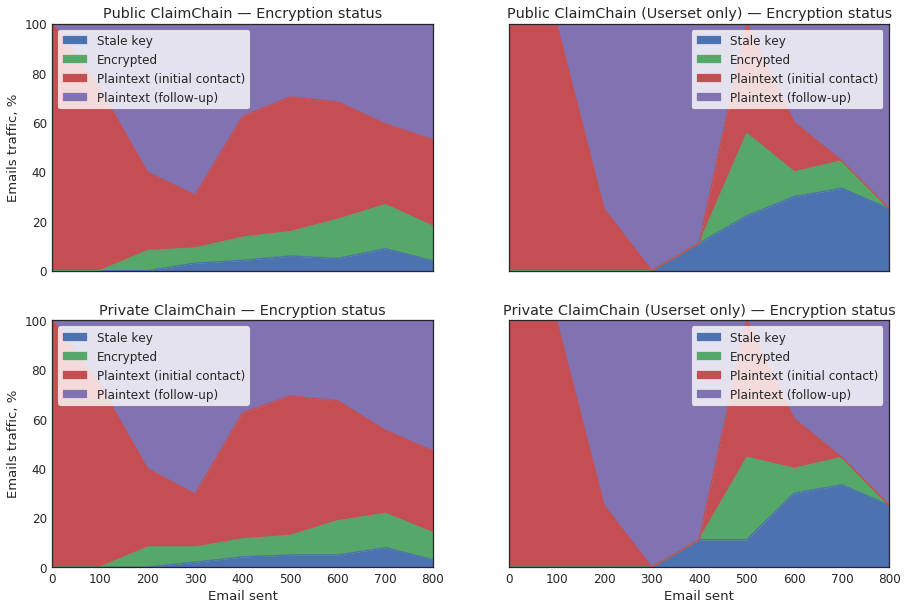

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
batch_size = 100

visualize_encryption_status_history('Public ClaimChain',
                                    public_report.encryption_status_data,
                                    public_report.link_status_data,
                                    batch_size=batch_size,
                                    ax=axes[0][0])

visualize_encryption_status_history('Private ClaimChain',
                                    private_report.encryption_status_data,
                                    private_report.link_status_data,
                                    batch_size=batch_size,
                                    ax=axes[1][0])

visualize_encryption_status_history('Public ClaimChain (Userset only)',
                                    public_report.encryption_status_data,
                                    public_report.link_status_data,
                                    public_report.participants_type_data == ParticipantsTypes.userset,
                                    batch_size=batch_size,
                                    ax=axes[0][1])

visualize_encryption_status_history('Private ClaimChain (Userset only)',
                                    private_report.encryption_status_data,
                                    private_report.link_status_data,
                                    private_report.participants_type_data == ParticipantsTypes.userset,
                                    batch_size=batch_size,
                                    ax=axes[1][1])

fig.set_figwidth(15)
fig.set_figheight(10)

## Simulate private ClaimChain at different starting points in the log

In [38]:
LOG_CHUNK_SIZE = 10000

In [9]:
private_reports = []
breakpoints = [int(i) for i in np.linspace(0, LOG_SIZE, 11)]

## Compute new reports
# for i in breakpoints[:-1]:
#     context = Context(enron_log[i : i + LOG_CHUNK_SIZE], social_graph=social_graph)
#     with dynamic_private_setting.as_default():
#         private_reports.append(simulate_claimchain(context))
#     with open('private_claimchain_report-%d.pkl' % i, 'wb') as h:
#         pickle.dump(private_reports[-1], h)

# Load reports
for i in breakpoints[:-1]:
    with open('private_claimchain_report-%d.pkl' % i, 'rb') as h:
        report = pickle.load(h)
        private_reports.append(report)

Global encryption traffic

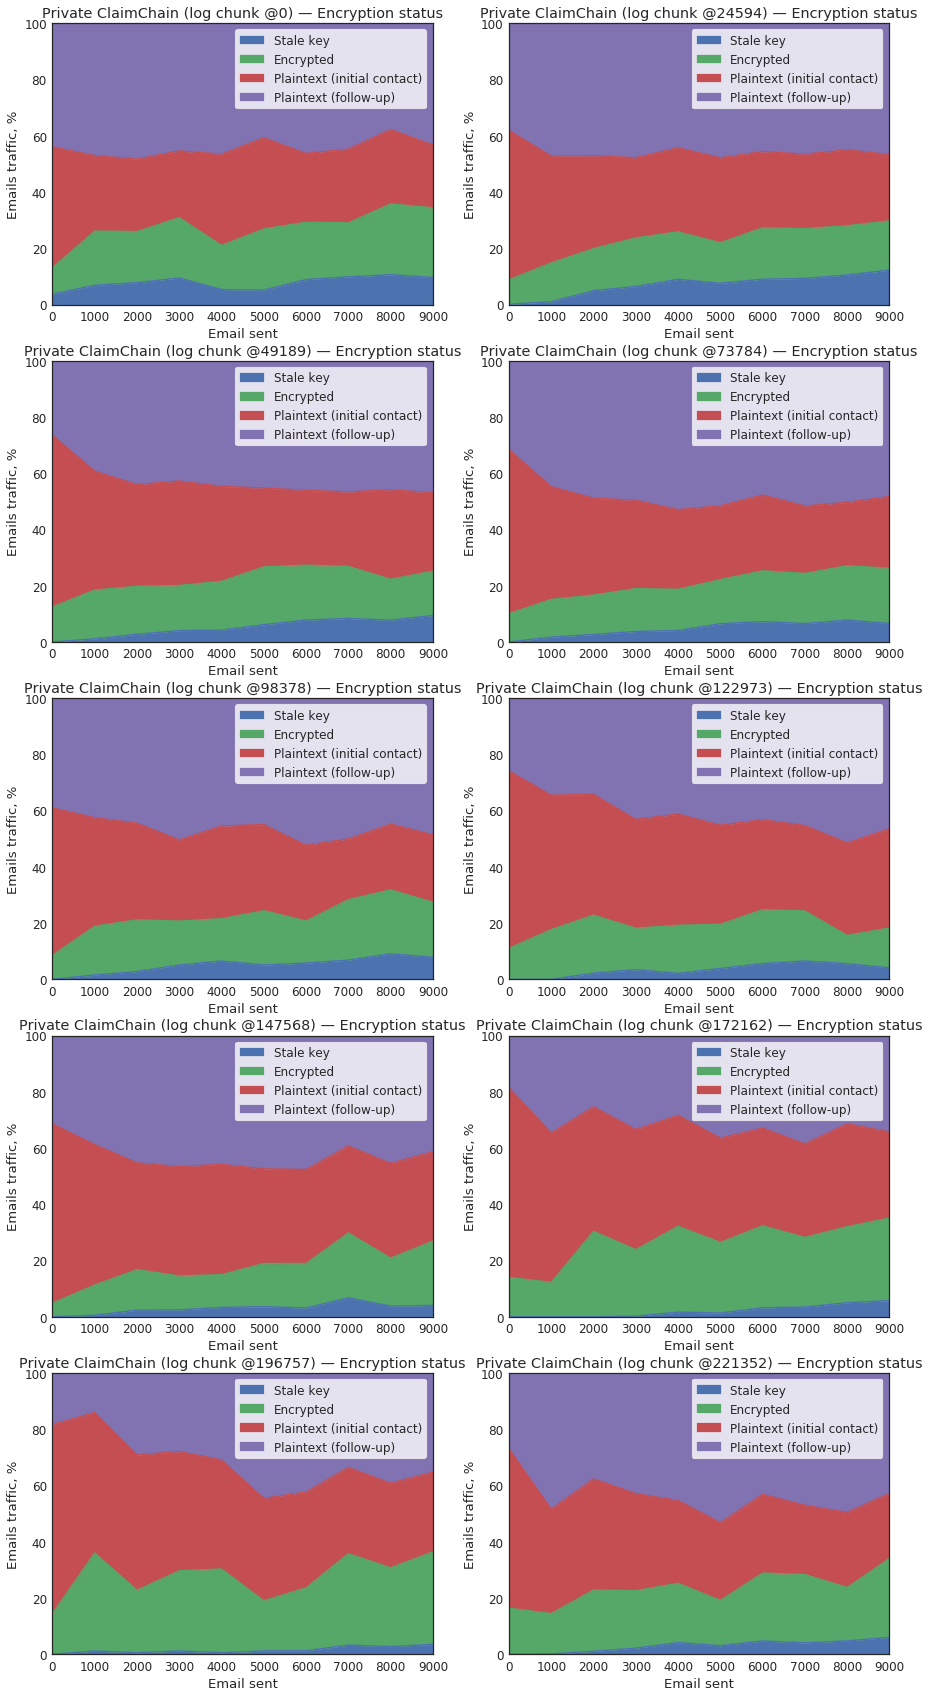

In [16]:
plot_encryption_status_plots('Private ClaimChain', private_reports, breakpoints=breakpoints)

Traffic within the userset

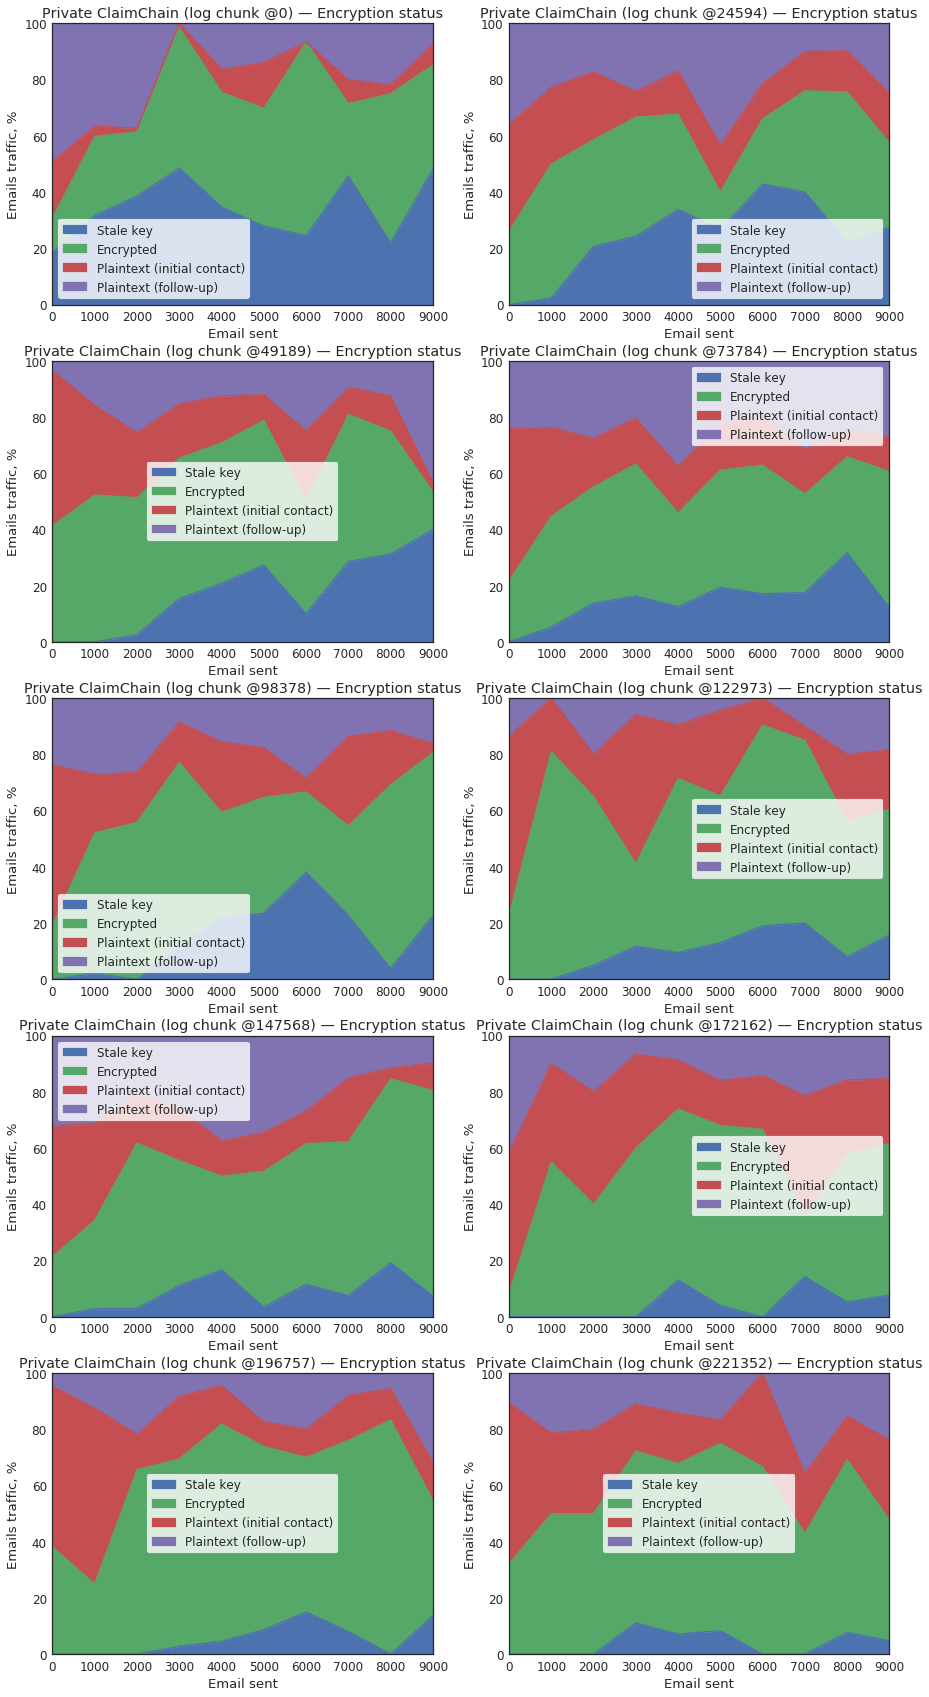

In [17]:
plot_encryption_status_plots('Private ClaimChain', private_reports, breakpoints=breakpoints,
                             mask_fn=lambda report: report.participants_type_data == ParticipantsTypes.userset)

Average encryption proportions

In [127]:
def get_average_enc_status_data(report, mask=None, batch_size=1000):
    cuts = [4000, 7000, 10000]

    enc_stats_batches = compute_enc_stats_in_batches(
        report.encryption_status_data, report.link_status_data, mask=mask)
    
    if mask is not None:
        enc_status_data = report.encryption_status_data[mask]
    else:
        enc_status_data = report.encryption_status_data
        
    enc_avg_data = pd.DataFrame(columns=['Last batch average', 'Overall average'])
    for cut in cuts:
        # Average of immediate %
        batch_avg = enc_stats_batches['Encrypted'].loc[cut-batch_size]

        # Overall average
        slice_stats = enc_status_data.loc[:cut].value_counts()
        nb_encrypted = slice_stats.get(EncStatus.encrypted) or 0 
        overall_avg = nb_encrypted / slice_stats.sum() * 100

        enc_avg_data.loc[cut] = (batch_avg, overall_avg)

    return enc_avg_data

In [43]:
for i, (offset, report) in enumerate(zip(breakpoints, private_reports)):
    print('@%d' % offset)
    a = get_average_enc_status_data(report)
    b = get_average_enc_status_data(report,
        mask=report.participants_type_data==ParticipantsTypes.userset)
    display(pd.concat({'global': a, 'userset': b}, axis=1))

@0


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           21.464903       17.320347          50.000000       28.187919
7000           20.344130       18.175096          68.888889       35.172414
10000          24.743326       19.649304          37.037037       35.727788

@24594


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           17.269076       13.689271          42.424242       37.820513
7000           18.274112       14.903777          23.214286       31.921824
10000          17.510121       15.705161          30.000000       34.324943

@49189


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           16.045549       15.707342          50.000000       48.550725
7000           19.487179       17.162103          40.000000       48.372093
10000          15.751295       16.903146          13.333333       44.630872

@73784


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           15.212982       13.127708          46.938776       37.908497
7000           18.061224       14.391843          45.714286       39.112903
10000          19.607843       15.731832          48.484848       38.786280

@98378


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           15.605749       14.932712          65.714286       46.202532
7000           14.978903       15.579386          28.571429       42.982456
10000          19.558360       17.273869          58.064516       45.602606

@122973


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           14.734561       16.077170          29.411765       48.750000
7000           19.173729       16.618387          71.428571       54.482759
10000          14.174972       15.873186          44.736842       53.070175

@147568


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           12.046908       10.503751          44.444444       39.516129
7000           15.800866       12.107692          50.000000       41.379310
10000          22.875817       14.780650          73.170732       49.535604

@172162


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           23.664921       20.179372          60.000000       43.055556
7000           29.149378       23.670412          66.666667       53.191489
10000          29.348986       24.687598          53.846154       50.802139

@196757


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           28.527291       25.090909          66.666667       54.285714
7000           22.327044       24.329159          55.000000       58.823529
10000          32.887975       26.383245          40.909091       60.000000

@221352


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           20.412371       18.257047          61.111111       45.714286
7000           24.137931       19.197156          66.666667       52.212389
10000          28.070175       20.587625          42.857143       50.931677

## Simulate public ClaimChain at one of the points (it's slower)

Pick one chunk

In [ ]:
offset = breakpoints[4]
private_report = private_reports[4]

In [121]:
## Compute new reports
#with dynamic_public_setting.as_default():
#    context = Context(enron_log[offset:offset+LOG_CHUNK_SIZE], social_graph=social_graph)
#    public_report = simulate_claimchain(context)
#with open('public_claimchain_report-%d.pkl' % offset, 'wb') as h:
#    pickle.dump(public_report, h)

with open('public_claimchain_report-%d.pkl' % offset, 'rb') as h:
    public_report = pickle.load(h)

Compare public and private versions

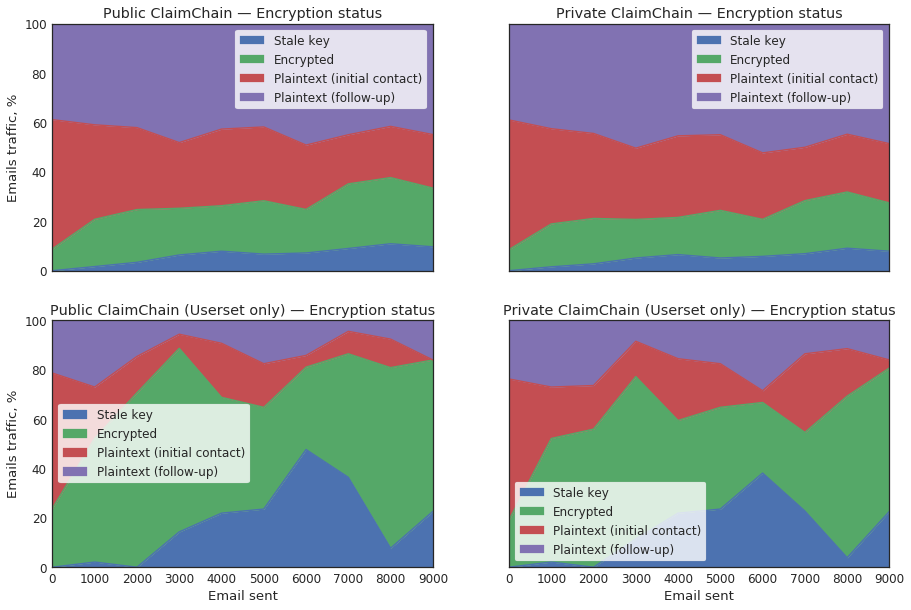

In [125]:

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True)
batch_size = 1000

visualize_encryption_status_history('Public ClaimChain',
                                    public_report.encryption_status_data,
                                    public_report.link_status_data,
                                    batch_size=batch_size,
                                    ax=axes[0][0])

visualize_encryption_status_history('Public ClaimChain (Userset only)',
                                    public_report.encryption_status_data,
                                    public_report.link_status_data,
                                    public_report.participants_type_data == ParticipantsTypes.userset,
                                    batch_size=batch_size,
                                    ax=axes[1][0])

visualize_encryption_status_history('Private ClaimChain',
                                    private_report.encryption_status_data,
                                    private_report.link_status_data,
                                    batch_size=batch_size,
                                    ax=axes[0][1])

visualize_encryption_status_history('Private ClaimChain (Userset only)',
                                    private_report.encryption_status_data,
                                    private_report.link_status_data,
                                    private_report.participants_type_data == ParticipantsTypes.userset,
                                    batch_size=batch_size,
                                    ax=axes[1][1])

fig.set_figwidth(15)
a = get_average_enc_status_data(private_report)
b = get_average_enc_status_data(private_report,
    mask=private_report.participants_type_data==ParticipantsTypes.userset)
display(pd.concat({'global': a, 'userset': b}, axis=1))fig.set_figheight(10)

In [128]:
print('Public ClaimChain')
a = get_average_enc_status_data(public_report)
b = get_average_enc_status_data(public_report,
    mask=private_report.participants_type_data==ParticipantsTypes.userset)
display(pd.concat({'global': a, 'userset': b}, axis=1))

print('Private ClaimChain')
a = get_average_enc_status_data(private_report)
b = get_average_enc_status_data(private_report,
    mask=private_report.participants_type_data==ParticipantsTypes.userset)
display(pd.concat({'global': a, 'userset': b}, axis=1))

Public ClaimChain


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           18.891170       17.028986          74.285714       52.531646
7000           17.616034       17.962466          33.333333       49.122807
10000          23.764458       20.226131          61.290323       52.442997

Private ClaimChain


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           15.605749       14.932712          65.714286       46.202532
7000           14.978903       15.579386          28.571429       42.982456
10000          19.558360       17.273869          58.064516       45.602606

## Visualize storage

In [92]:
def get_average_storage_data(report, batch_size=2500):
    
    def collect_data_points(series_dict):
        data_points_by_batch = defaultdict(list)
        for offset in range(0, LOG_CHUNK_SIZE, batch_size):
            for series in series_dict.values():
                data_slice = series.loc[offset:offset + batch_size] \
                            .dropna().values
                if len(data_slice) == 0:
                    continue
                data_point = data_slice.mean() / 1024
                data_points_by_batch[offset + batch_size].append(data_point)

        for offset in range(0, LOG_CHUNK_SIZE, batch_size):
            points = data_points_by_batch[offset + batch_size]
            data_points_by_batch[offset + batch_size] = pd.Series(points)

        result = pd.DataFrame(data_points_by_batch)
        return result

    bandwidth_data = collect_data_points(report.outgoing_bandwidth_data)
    gossip_storage_data = collect_data_points(report.gossip_store_size_data)
    local_storage_data = collect_data_points(report.local_store_size_data)
    
    return bandwidth_data, gossip_storage_data, local_storage_data

In [109]:
report = private_reports[4]
bandwidth_data, gossip_storage_data, local_storage_data = \
    get_average_storage_data(report)

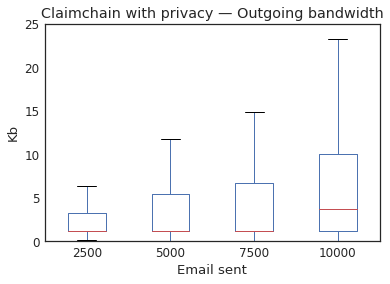

In [115]:
fig, ax = plt.subplots()

ax.legend(frameon=True, loc="right bottom")
ax.set_title("%s — Outgoing bandwidth" % scenario_name)
ax.set_ylabel("Kb")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 25)
bandwidth_data.plot.box(ax=ax)

fig.savefig(scenario_name.lower().replace(' ', '_') + '_bandwidth.pdf')

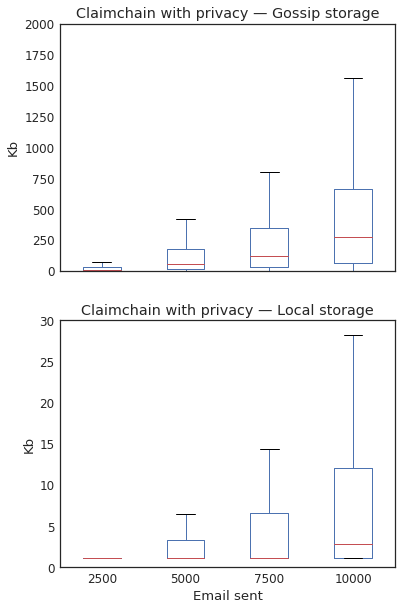

In [112]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

axes[0].set_title("%s — Gossip storage" % scenario_name)
axes[0].set_ylabel("Kb")
axes[0].set_xlabel("Email sent")
axes[0].set_ylim(0, 2000)
gossip_storage_data.plot.box(ax=axes[0])

axes[1].set_title("%s — Local storage" % scenario_name)
axes[1].set_ylabel("Kb")
axes[1].set_xlabel("Email sent")
axes[1].set_ylim(0, 30)
local_storage_data.plot.box(ax=axes[1])

fig.set_figheight(10)
fig.savefig(scenario_name.lower().replace(' ', '_') + '_gossip_storage.pdf')